In [1]:
import numpy as np
from tqdm import tqdm
import cv2
import os
import shutil
import itertools
import imutils
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix

import plotly.graph_objs as go
from plotly.offline import init_notebook_mode, iplot
from plotly import tools

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras import layers
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.callbacks import EarlyStopping

# Baseline performance

### Total instances
120+75=195

### Most frequent class
Yes (120 instances)

### Baseline accuracy (Training Set)
120/195 = 0.6154% (61.54%)


### Import Data

In [2]:
PATHS = {
    'Test': './data/test/',
    'Train': './data/train/',
    'Val':'./data/val/'
    }

In [3]:
def load_data(dir_path):
    X = []
    y = []
    labels = {}
    for i, folder_name in enumerate(tqdm(sorted(os.listdir(dir_path)))):
        folder_path = os.path.join(dir_path, folder_name)
        if os.path.isdir(folder_path):
            labels[i] = folder_name
            for file_name in os.listdir(folder_path):
                file_path = os.path.join(folder_path, file_name)
                if file_name.lower().endswith(('.png', '.jpg', '.jpeg')):
                    img = cv2.imread(file_path)
                    if img is not None:
                        img = cv2.resize(img, (224, 224))
                        X.append(img)
                        y.append(i)
    X = np.array(X)
    y = np.array(y)
    print(f'{len(X)} images loaded from {dir_path} directory.')
    return X, y, labels

In [4]:
X_train, y_train, labels = load_data(PATHS['Train'])
X_test, y_test, _ = load_data(PATHS['Test'])
X_val, y_val, _ = load_data(PATHS['Val'])

100%|██████████| 2/2 [00:00<00:00,  2.07it/s]


191 images loaded from ./data/train/ directory.


100%|██████████| 2/2 [00:00<00:00, 30.99it/s]


14 images loaded from ./data/test/ directory.


100%|██████████| 2/2 [00:00<00:00,  9.23it/s]

48 images loaded from ./data/val/ directory.


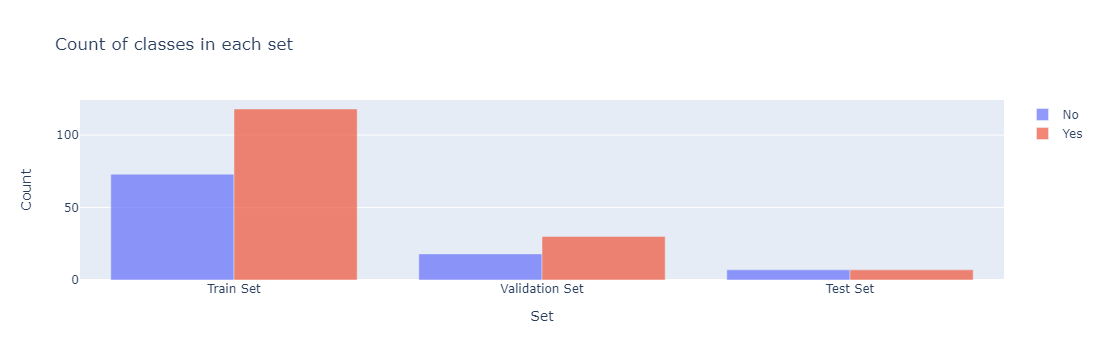

In [5]:
init_notebook_mode(connected=True)

class_counts = {0: [], 1: []}

for set_name in (y_train, y_val, y_test):
    for key in class_counts.keys():
        class_counts[key].append(np.sum(set_name == key))

traces = []
for class_id, counts in class_counts.items():
    trace = go.Bar(
        x=['Train Set', 'Validation Set', 'Test Set'],
        y=counts,
        name='No' if class_id == 0 else 'Yes',
        opacity=0.7
    )
    traces.append(trace)

layout = go.Layout(
    title='Count of classes in each set',
    xaxis={'title': 'Set'},
    yaxis={'title': 'Count'},
    barmode='group' 
)

fig = go.Figure(data=traces, layout=layout)
iplot(fig)


### Plot sample images

In [6]:
def plot_samples(X, y, labels_dict, n):
    
    columns = 10
    rows = n // columns + (n % columns > 0)
    
    for index, label in labels_dict.items():
        indexes = np.flatnonzero(y == index)[:n]
        selected_imgs = X[indexes]
        
        plt.figure(figsize=(15, 6))
        for c, img in enumerate(selected_imgs, start=1):
            plt.subplot(rows, columns, c)
            plt.imshow(img)
            plt.xticks([])
            plt.yticks([])

        plt.suptitle(f'Tumor: {label.upper()}')
        plt.show()


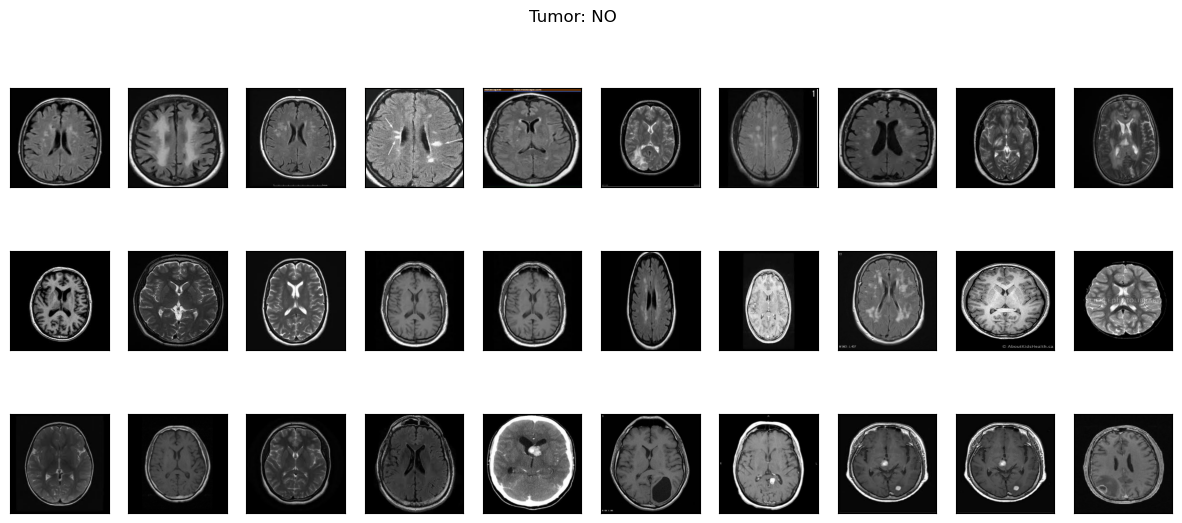

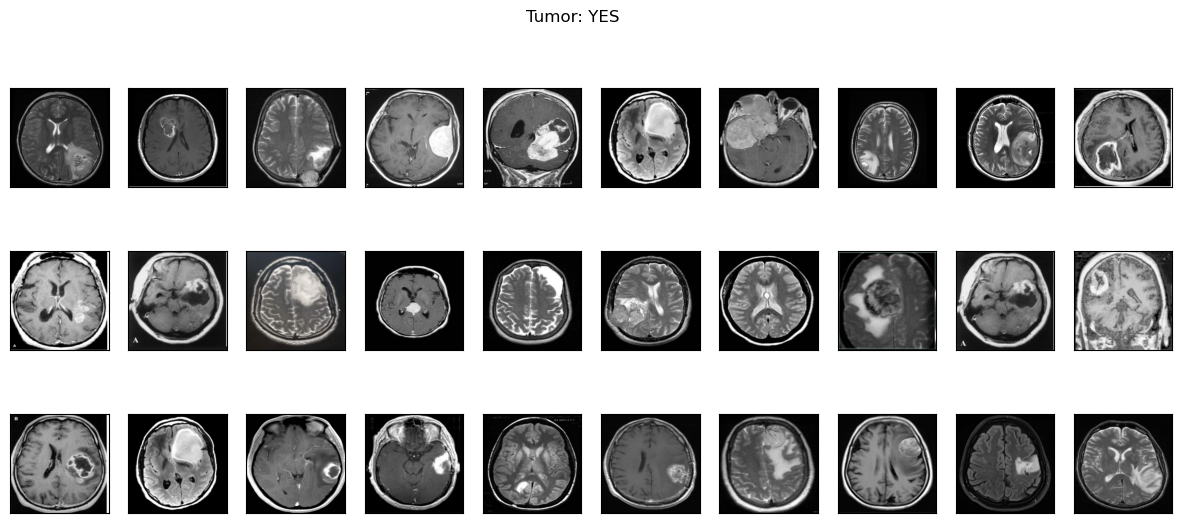

In [7]:
plot_samples(X_train, y_train, labels, 30)

### Image Processing

In [8]:
def crop_imgs(set_name, add_pixels_value=0):
    set_new = []
    for img in set_name:
        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        gray = cv2.GaussianBlur(gray, (5, 5), 0)

        # threshold the image, then perform a series of erosions +
        # dilations to remove any small regions of noise
        thresh = cv2.threshold(gray, 45, 255, cv2.THRESH_BINARY)[1]
        thresh = cv2.erode(thresh, None, iterations=2)
        thresh = cv2.dilate(thresh, None, iterations=2)

        # find contours in thresholded image, then grab the largest one
        cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        cnts = imutils.grab_contours(cnts)
        c = max(cnts, key=cv2.contourArea)

        # find the extreme points
        extLeft = tuple(c[c[:, :, 0].argmin()][0])
        extRight = tuple(c[c[:, :, 0].argmax()][0])
        extTop = tuple(c[c[:, :, 1].argmin()][0])
        extBot = tuple(c[c[:, :, 1].argmax()][0])

        ADD_PIXELS = add_pixels_value
        new_img = img[extTop[1]-ADD_PIXELS:extBot[1]+ADD_PIXELS, extLeft[0]-ADD_PIXELS:extRight[0]+ADD_PIXELS].copy()
        
        # Inside your loop, after cropping:
        new_img_resized = cv2.resize(new_img, (224, 224))
        set_new.append(new_img_resized)


    return np.array(set_new)

In [9]:
X_train_crop = crop_imgs(set_name=X_train)
X_val_crop = crop_imgs(set_name=X_val)
X_test_crop = crop_imgs(set_name=X_test)

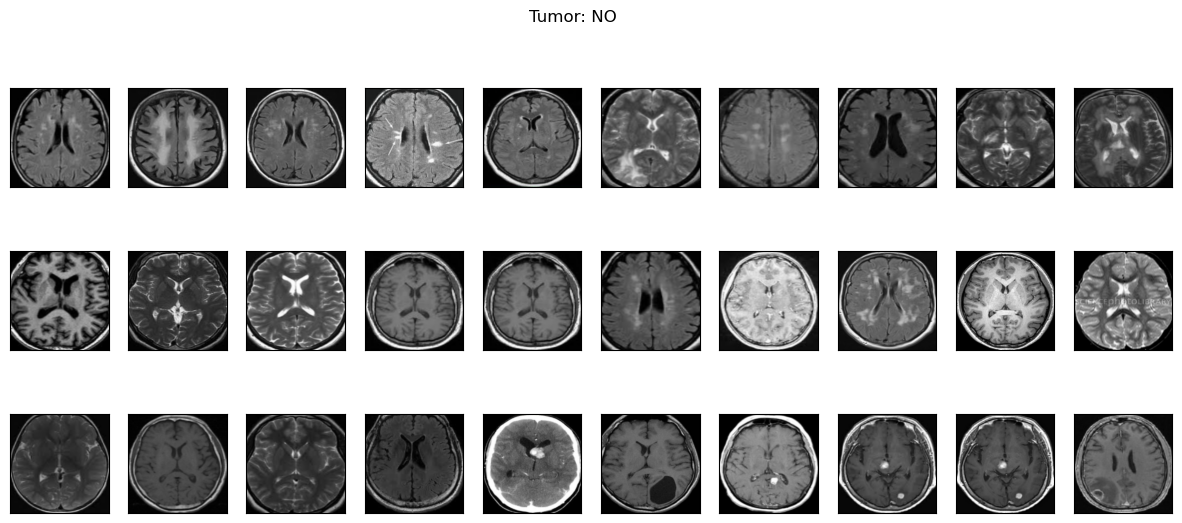

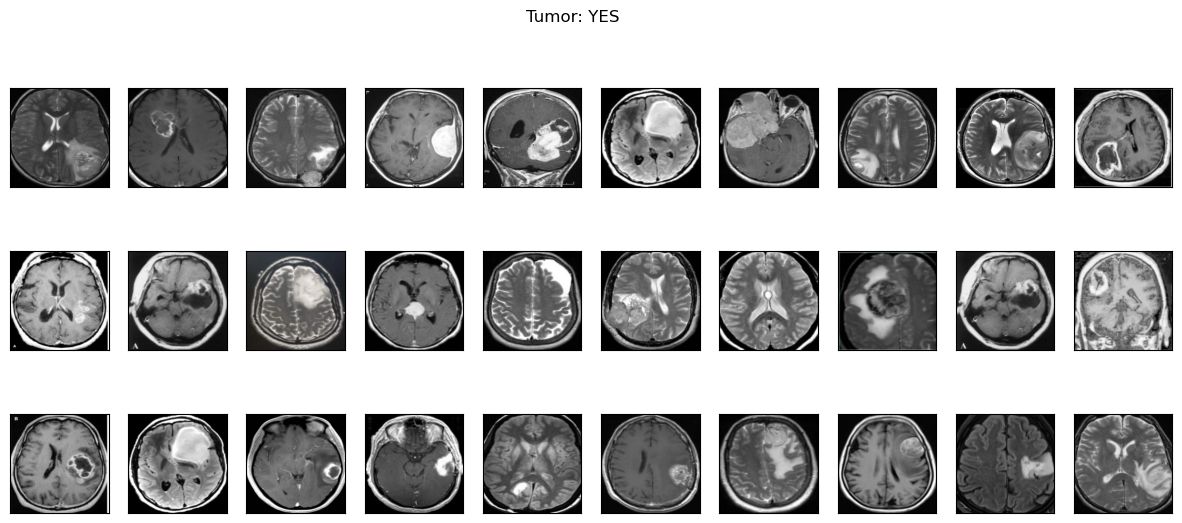

In [10]:
plot_samples(X_train_crop, y_train, labels, 30)

In [11]:
def save_new_images(x_set, y_set, folder_name):
    i = 0
    for (img, imclass) in zip(x_set, y_set):
        if imclass == 0:
            cv2.imwrite(folder_name+'NO/'+str(i)+'.jpg', img)
        else:
            cv2.imwrite(folder_name+'YES/'+str(i)+'.jpg', img)
        i += 1

In [12]:
save_new_images(X_train_crop, y_train, folder_name='./data/train_crop/')
save_new_images(X_val_crop, y_val, folder_name='./data/val_crop/')
save_new_images(X_test_crop, y_test, folder_name='./data/test_crop/')

In [13]:
def preprocess_imgs(set_name):
    set_new = []
    for img in set_name:
        resized_img = cv2.resize(img, dsize=(224,224), interpolation=cv2.INTER_CUBIC)
        set_new.append(preprocess_input(resized_img))
    return np.array(set_new)


In [14]:
X_train_prep = preprocess_imgs(set_name=X_train_crop)
X_test_prep = preprocess_imgs(set_name=X_test_crop)
X_val_prep = preprocess_imgs(set_name=X_val_crop)

### Data Augmentation

In [15]:
demo_datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.05,
    height_shift_range=0.05,
    rescale=1./255,
    shear_range=0.05,
    brightness_range=[0.1, 1.5],
    horizontal_flip=True,
    vertical_flip=True
)

In [16]:
preview_dir = 'preview'
if not os.path.exists(preview_dir):
    os.mkdir(preview_dir)
    
x = X_train_crop[0]
x = x.reshape((1,) + x.shape)

counter = 0

for batch in demo_datagen.flow(x, batch_size=1, save_to_dir=preview_dir, save_prefix='aug_img', save_format='jpg'):
    counter += 1
    if counter > 20:
        break

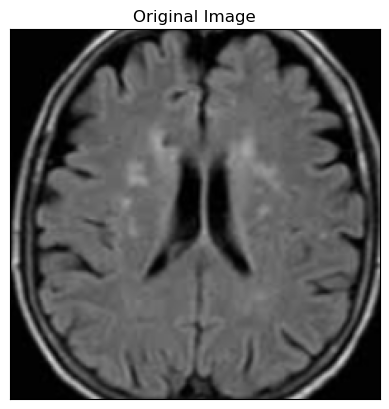

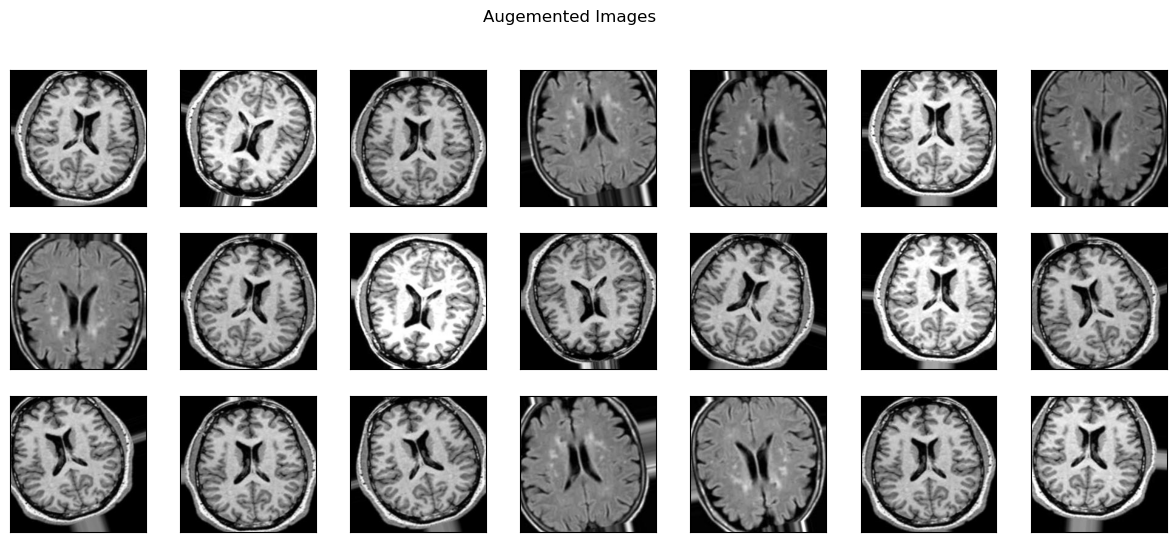

In [17]:
plt.imshow(X_train_crop[0])
plt.xticks([])
plt.yticks([])
plt.title('Original Image')
plt.show()

plt.figure(figsize=(15,6))
i = 1
for img in os.listdir('preview/'):
    img = cv2.imread('preview/' + img)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.subplot(3,7,i)
    plt.imshow(img)
    plt.xticks([])
    plt.yticks([])
    i += 1
    if i > 3*7:
        break
plt.suptitle('Augemented Images')
plt.show()

### Model Building

In [18]:
base_model = VGG16(
    include_top=False, 
    input_shape=(224, 224)  + (3,), 
    weights='imagenet' 
)

In [19]:
NUM_CLASSES = 1

model = Sequential([
    base_model,
    layers.Flatten(),
    layers.Dropout(0.5),
    layers.Dense(NUM_CLASSES, activation='sigmoid')
])

base_model.trainable = False

model.compile(
    optimizer=RMSprop(learning_rate=1e-4),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 25088)             0         
                                                                 
 dropout (Dropout)           (None, 25088)             0         
                                                                 
 dense (Dense)               (None, 1)                 25089     
                                                                 
Total params: 14739777 (56.23 MB)
Trainable params: 25089 (98.00 KB)
Non-trainable params: 14714688 (56.13 MB)
_________________________________________________________________


### Train Model

In [20]:
import warnings
warnings.filterwarnings('ignore')

EPOCHS = 30

es = EarlyStopping(
    monitor='val_accuracy',
    mode='max',
    patience=6
)

TRAIN_DIR = './data/train_crop/'
VAL_DIR = './data/val_crop/'

train_datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    brightness_range=[0.5, 1.5],
    horizontal_flip=True,
    vertical_flip=True,
    preprocessing_function=preprocess_input
)

test_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input
)

train_generator = train_datagen.flow_from_directory(
    TRAIN_DIR,
    color_mode='rgb',
    target_size=(224,224),
    batch_size=32,
    class_mode='binary',
    seed=123
)

validation_generator = test_datagen.flow_from_directory(
    VAL_DIR,
    color_mode='rgb',
    target_size=(224,224),
    batch_size=8,        
    class_mode='binary',
    seed=123
)

history = model.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    epochs=EPOCHS,
    validation_data=validation_generator,
    validation_steps=len(validation_generator),
    callbacks=[es] 
)


Found 197 images belonging to 2 classes.
Found 48 images belonging to 2 classes.
Epoch 1/30


7/7 [==============================] - 15s 2s/step - loss: 6.2739 - accuracy: 0.4569 - val_loss: 2.3231 - val_accuracy: 0.6042
Epoch 2/30
7/7 [==============================] - 13s 2s/step - loss: 3.9681 - accuracy: 0.5635 - val_loss: 1.7662 - val_accuracy: 0.6042
Epoch 3/30
7/7 [==============================] - 13s 2s/step - loss: 4.5291 - accuracy: 0.5584 - val_loss: 1.4354 - val_accuracy: 0.7083
Epoch 4/30
7/7 [==============================] - 13s 2s/step - loss: 3.4643 - accuracy: 0.6091 - val_loss: 1.5246 - val_accuracy: 0.7917
Epoch 5/30
7/7 [==============================] - 13s 2s/step - loss: 4.0141 - accuracy: 0.6142 - val_loss: 1.1393 - val_accuracy: 0.7917
Epoch 6/30
7/7 [==============================] - 14s 2s/step - loss: 3.7121 - accuracy: 0.6244 - val_loss: 0.9806 - val_accuracy: 0.7500
Epoch 7/30
7/7 [==============================] - 14s 2s/step - loss: 3.5015 - accuracy: 

### Model Performance

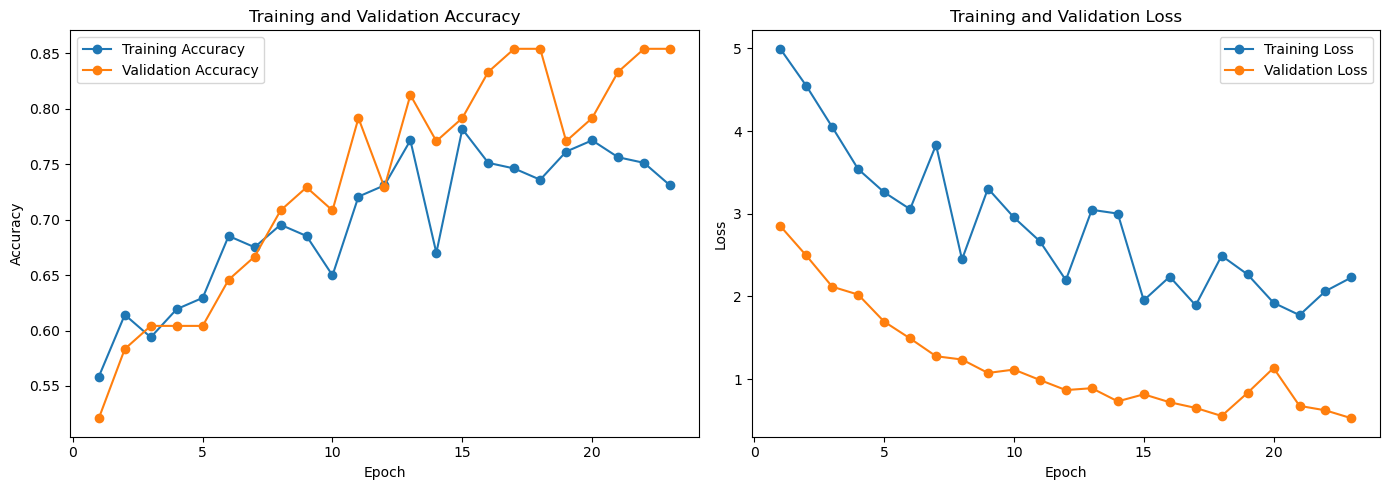

In [71]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(1, len(acc) + 1)

plt.figure(figsize=(14, 5)) 

plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy', marker='o') 
plt.plot(epochs_range, val_acc, label='Validation Accuracy', marker='o')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss', marker='o')
plt.plot(epochs_range, val_loss, label='Validation Loss', marker='o')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.tight_layout() 
plt.show()

In [68]:
def plot_confusion_matrix(cm, classes):

    plt.figure(figsize=(6, 6))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title("Confusion Matrix")
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45) 
    plt.yticks(tick_marks, classes)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()


2/2 [==============================] - 3s 973ms/step
Val Accuracy = 0.88


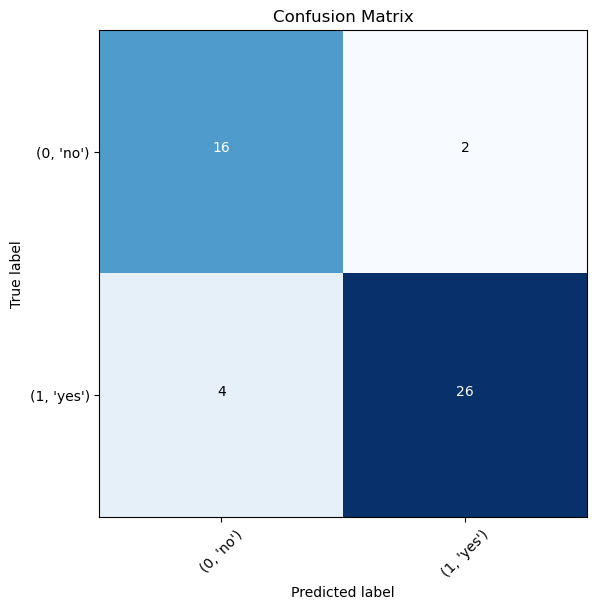

[[16  2]
 [ 4 26]]


In [69]:
# validate on val set
predictions = model.predict(X_val_prep)
predictions = [1 if x>0.5 else 0 for x in predictions]

accuracy = accuracy_score(y_val, predictions)
print('Val Accuracy = %.2f' % accuracy)

confusion_mtx = confusion_matrix(y_val, predictions) 
cm = plot_confusion_matrix(confusion_mtx, classes = list(labels.items()))
print(confusion_mtx)

**True Negatives (TN)** = 16: The model correctly predicted the negative class (class 0) 16 times.

**False Positives (FP)** = 2: The model incorrectly predicted the positive class (class 1) 2 times when the true class was negative (class 0)

**False Negatives (FN)** = 4: The model incorrectly predicted the negative class (class 0) 4 times when the true class was positive (class 1)

**True Positives (TP)** = 26: The model correctly predicted the positive class (class 1) 26 times


**Accuracy**: Approximately 89.58%, indicating a high overall rate of correct predictions.

**Precision for Class 1**: Approximately 96.30%, showing that the model is highly accurate when it predicts the positive class.

**Recall (Sensitivity) for Class 1**: Approximately 86.67%, reflecting the model's ability to identify the positive class.

**Specificity for Class 0**: Approximately 91.23%, indicating a good balance between precision and recall.


1/1 [==============================] - 1s 970ms/step
Test Accuracy = 0.86


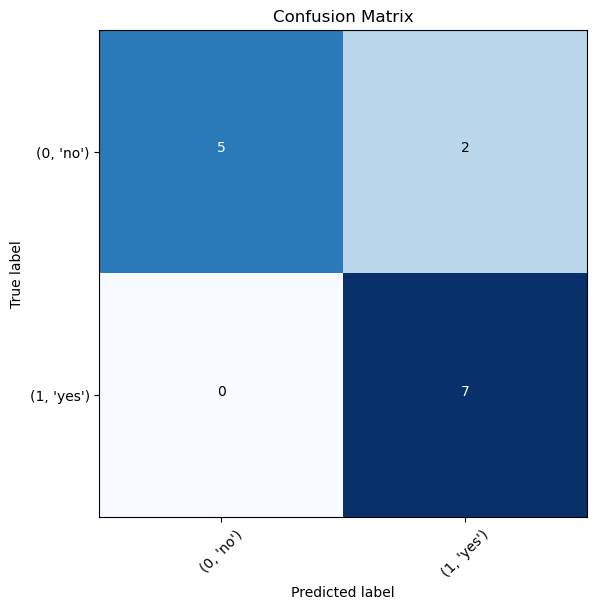

[[5 2]
 [0 7]]


In [70]:
# validate on test set
predictions = model.predict(X_test_prep)
predictions = [1 if x>0.5 else 0 for x in predictions]

accuracy = accuracy_score(y_test, predictions)
print('Test Accuracy = %.2f' % accuracy)

confusion_mtx = confusion_matrix(y_test, predictions) 
cm = plot_confusion_matrix(confusion_mtx, classes = list(labels.items()))
print(confusion_mtx)

**True Negatives (TN)**: The model correctly predicted the negative class (class 0) 5 times.

**False Positives (FP)**: The model incorrectly predicted the positive class (class 1) 2 times when the true class was negative (class 0)

**False Negatives (FN)**: The model incorrectly predicted the negative class (class 0) 0 times when the true class was positive (class 1)

**True Positives (TP)**: The model correctly predicted the positive class (class 1) 7 times

Accuracy: 85.71%

Precision: 77.78%

Recall (Sensitivity): 100%

F1 Score: 87.5%